# Anonymization de données Medicales

## 1. Analyse de données

In [471]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("./Copy of MedicalRecordsDataset.csv")

### 1.1. Vérification de données et compréhension des données

In [472]:
df.head(10)

,Name,Age,Sex,Zip_Code,Disease,Test_Date,Result
0,Andrew Robinson,57,Male,64217,Hypertension,2021-10-31,Negative
1,Andrew Robinson,57,Male,64219,Asthma,2021-03-15,Positive
2,Andrew Robinson,57,Male,64221,COVID-19,2022-06-02,Positive
3,Andrew Robinson,57,Male,64221,Cancer,2023-01-23,Positive
4,Roy Rodriguez,79,Male,24012,Diabetes,2020-01-12,Positive
5,Roy Rodriguez,79,Male,24013,COVID-19,2020-03-06,Positive
6,Roy Rodriguez,79,Male,24011,Hypertension,2022-09-12,Negative
7,Roy Rodriguez,79,Male,24009,Cancer,2024-01-08,Positive
8,Roy Rodriguez,79,Male,24010,Cancer,2023-05-11,Negative
9,Daniel Cook,39,Male,19260,Cancer,2020-01-16,Positive


In [473]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Name       414 non-null    object
 1   Age        414 non-null    int64 
 2   Sex        414 non-null    object
 3   Zip_Code   414 non-null    int64 
 4   Disease    414 non-null    object
 5   Test_Date  414 non-null    object
 6   Result     414 non-null    object
dtypes: int64(2), object(5)
memory usage: 22.8+ KB


In [474]:
df.isnull().sum()

Name         0
Age          0
Sex          0
Zip_Code     0
Disease      0
Test_Date    0
Result       0
dtype: int64

### 1.2. Obtention des informations importantes sur bases de données

In [475]:
# quasi_cols1 = ['Age', 'Sex', 'Zip_Code']
# quasi_cols2 = ['Age', 'Sex']
# col = ['Name', 'Age', 'Sex', 'Zip_Code']

In [476]:
# df[quasi_cols1].duplicated().value_counts()

In [477]:
# df[quasi_cols2].duplicated().value_counts()

In [478]:
# df[col].duplicated().value_counts()

In [479]:
def uniqueness_analysis(df, column_groups):
    results = []
    for cols in column_groups:
        dup_series = df[cols].duplicated(keep=False)
        total = len(df)
        unique = (~dup_series).sum()
        label = " + ".join(cols)
        results.append({
            'Combination': label,
            'Unique Row Count': unique,
            'Number of duplicate rows': total - unique,
            'Unique ratio': unique / total
        })
    
    result_df = pd.DataFrame(results)
    
    ax = result_df.set_index('Combination')[['Unique ratio']].plot(kind='barh', legend=False, figsize=(8,4), color='skyblue')
    for i, v in enumerate(result_df['Unique ratio']):
        ax.text(v + 0.01, i, f"{v:.2%}", va='center')
    plt.title("Unique ratio of different combinations of identifiers")
    plt.xlabel("Unique ratio")
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()
    
    return result_df


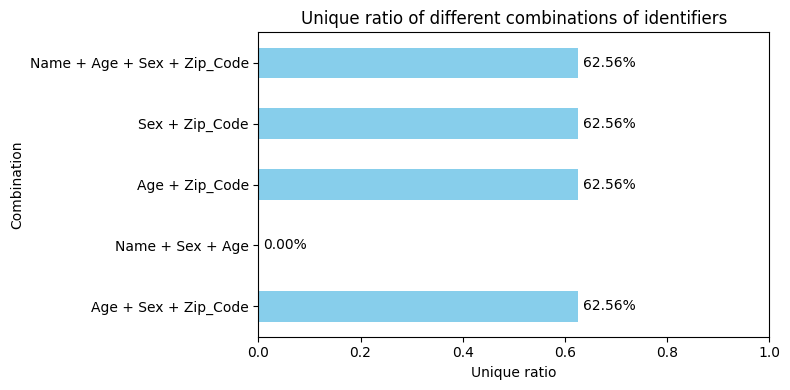

,Combination,Unique Row Count,Number of duplicate rows,Unique ratio
0,Age + Sex + Zip_Code,259,155,0.625604
1,Name + Sex + Age,0,414,0.000000
2,Age + Zip_Code,259,155,0.625604
3,Sex + Zip_Code,259,155,0.625604
4,Name + Age + Sex + Zip_Code,259,155,0.625604


In [480]:
col_groups = [
    ['Age', 'Sex', 'Zip_Code'],
    ['Name', 'Sex', 'Age'],
    ['Age', 'Zip_Code'],
    ['Sex', 'Zip_Code'],
    ['Name', 'Age', 'Sex', 'Zip_Code']
]

uniqueness_analysis(df, col_groups)


In [481]:
def calculate_uniqueness_weights(df, columns):
    total_rows = len(df)
    weights = {}
    for col in columns:
        unique_count = df[col].nunique()
        uniqueness_score = unique_count / total_rows
        weights[col] = uniqueness_score
    return pd.Series(weights).sort_values(ascending=False)


In [482]:
identifiers = ['Name','Age','Zip_Code', 'Disease', 'Test_Date']
calculate_uniqueness_weights(df, identifiers)

Test_Date    0.876812
Zip_Code     0.801932
Name         0.241546
Age          0.123188
Disease      0.014493
dtype: float64

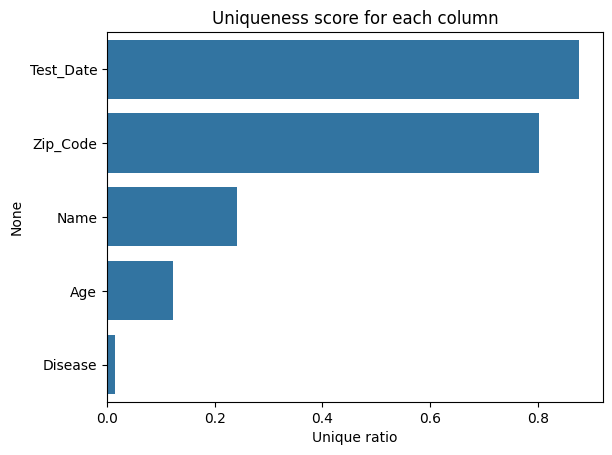

In [483]:
weights = calculate_uniqueness_weights(df, identifiers)
sns.barplot(x=weights.values, y=weights.index)
plt.title("Uniqueness score for each column")
plt.xlabel("Unique ratio")
plt.show()


**Unique ratio est plus élevé, les attributs sont plus facile pour identifier les patients.**

J'ai trouvé que Unique ratio d'Age et de Disease sont plus basses que les autres. C'est facile pour analyser leur distribution. Par ailleurs, pour attribut age, je pense qu'il y a plusieur façon pour l'anonymiser. On peut choisir le méthode spécifique pour le traiter via la distribution. 

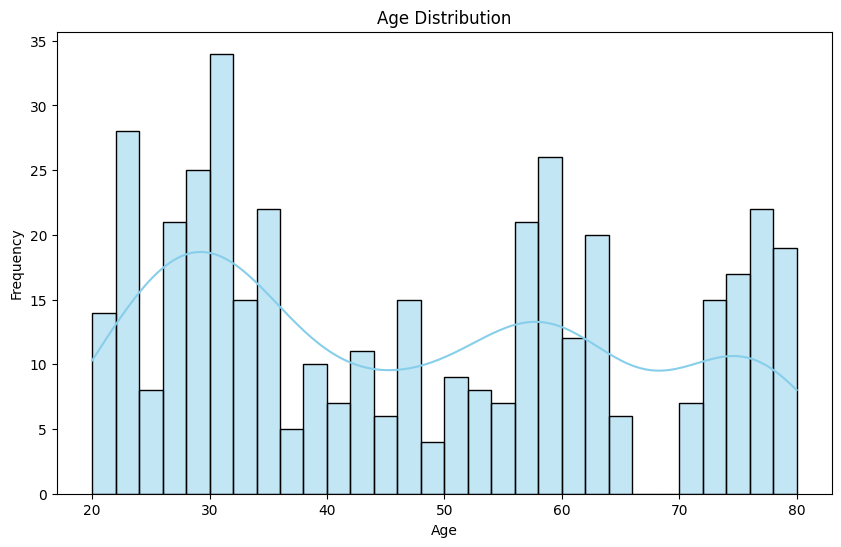

In [484]:
# Distribution of Age
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=30, kde=True, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')

plt.ylabel('Frequency')
plt.show()

C:\Users\30586\AppData\Local\Temp\ipykernel_9892\1720527721.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Disease', palette='viridis')


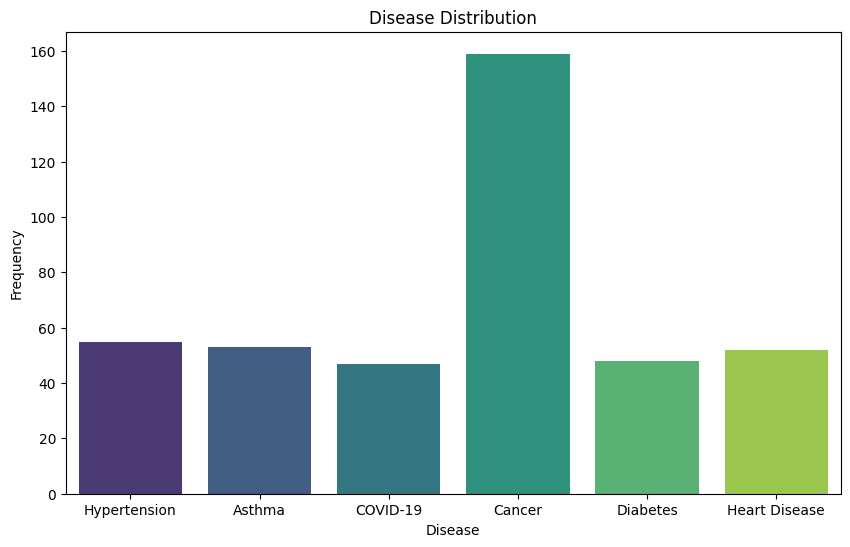

In [485]:
## Distribution of disease
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Disease', palette='viridis')
plt.title('Disease Distribution')
plt.xlabel('Disease')
plt.ylabel('Frequency')
plt.show()

## 2. Anonymization de données

In [486]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Name       414 non-null    object
 1   Age        414 non-null    int64 
 2   Sex        414 non-null    object
 3   Zip_Code   414 non-null    int64 
 4   Disease    414 non-null    object
 5   Test_Date  414 non-null    object
 6   Result     414 non-null    object
dtypes: int64(2), object(5)
memory usage: 22.8+ KB


**Name:**: C'est identifier le plus important pour l'identification des patients, il sera remplacé par un identifiant aléatoire.(III. Techniques for Non-Numeric Columns) Ici je peux supprimer directement. Mais j'aimerais utiliser Tokenization pour l'anonymiser.

**Sex**: C'est quais-identifier, mais je pense pas qu'il est obligatoire de l'anonymiser via l'analyse. Sinon je pense que l'on peut utiliser Binary pour remplacer le genre ou bien le supprimer.

**Age:**: C'est quais-identifier(I. Techniques for Discrete Numbers) -> normalement, on n'a pas besoin de l'anonymiser, parce que dans les combinaison de quasi-identifier(Name + Sex + Age	), Unique Row Count est 0. Mais ici quand même on l'anonymise pour pratiquer

**Zip_Code:**: C'est quasi-identifier(I. Techniques for Discrete Numbers)

**Test Date**: on peut identifier les patients via Test Date. Sur les données, le format de données sont YYYY-MM-DD, Je pense que l'on peut généraliser les dates pour les rendre anonymes.Mais les données sont pas beaucoup et aussi Unique_ratio est très élevé, donc je pense que l'on peut ajouter les bruits pour les rendre anonymes.

**Disease et Result** c'est infos sensibles.


### 2.1. Anonymisation de données(M1)

#### 2.1.1. Pour les identifier "Name"

Je utilise Pseudonymization, c'est possible de restaurer(faker),mais ici je donne pas le seed fixé, donc il ne peux pas être restauré

In [487]:
from faker import Faker

In [488]:
df_Anonymization_1 = df.copy()

# df_Anonymization_1[['First_Name', 'Last_Name']] = df_Anonymization_1['Name'].str.split(" ",1,expand=True)
# df_Anonymization_1['Name_Token'] = df_Anonymization_1['First_Name'].str[0] + ". " + df['Last_Name']
faker = Faker()
df_Anonymization_1['Fake_Name'] = [faker.name() for _ in range(len(df_Anonymization_1))]
df_Anonymization_1.drop(columns=['Name'], inplace=True)
df_Anonymization_1.insert(0, 'Name', df_Anonymization_1['Fake_Name'])
df_Anonymization_1.drop(columns=['Fake_Name'], inplace=True)

In [489]:
df

,Name,Age,Sex,Zip_Code,Disease,Test_Date,Result
0,Andrew Robinson,57,Male,64217,Hypertension,2021-10-31,Negative
1,Andrew Robinson,57,Male,64219,Asthma,2021-03-15,Positive
2,Andrew Robinson,57,Male,64221,COVID-19,2022-06-02,Positive
3,Andrew Robinson,57,Male,64221,Cancer,2023-01-23,Positive
4,Roy Rodriguez,79,Male,24012,Diabetes,2020-01-12,Positive
...,...,...,...,...,...,...,...
409,Clarence Moss,59,Male,32221,Hypertension,2021-09-16,Negative
410,Clarence Moss,59,Male,32222,Cancer,2020-02-21,Positive
411,Kathy Arnold,41,Female,81231,Asthma,2022-05-11,Positive
412,Kathy Arnold,41,Female,81229,Cancer,2021-12-06,Positive


In [490]:
df_Anonymization_1

,Name,Age,Sex,Zip_Code,Disease,Test_Date,Result
0,Erica Morrison,57,Male,64217,Hypertension,2021-10-31,Negative
1,Russell Watkins,57,Male,64219,Asthma,2021-03-15,Positive
2,Gail Miller,57,Male,64221,COVID-19,2022-06-02,Positive
3,Oscar Massey,57,Male,64221,Cancer,2023-01-23,Positive
4,Diana Powell,79,Male,24012,Diabetes,2020-01-12,Positive
...,...,...,...,...,...,...,...
409,Roger Jimenez,59,Male,32221,Hypertension,2021-09-16,Negative
410,Jessica Hubbard,59,Male,32222,Cancer,2020-02-21,Positive
411,Joshua Adams,41,Female,81231,Asthma,2022-05-11,Positive
412,Angela Smith,41,Female,81229,Cancer,2021-12-06,Positive


#### 2.1.2. Pour les quasi-identifier "Age"

In [491]:
df['Age'].min()

20

In [492]:
df['Age'].max()

80

In [493]:
bins = [20, 30, 40, 50, 60, 70, 81]
labels = ['20-30', '30-40', '40-50', '50-60', '60-70', '70-81']
df_Anonymization_1['Age'] = pd.cut(df_Anonymization_1['Age'], bins=bins, labels=labels, right=False)

In [494]:
df_Anonymization_1

,Name,Age,Sex,Zip_Code,Disease,Test_Date,Result
0,Erica Morrison,50-60,Male,64217,Hypertension,2021-10-31,Negative
1,Russell Watkins,50-60,Male,64219,Asthma,2021-03-15,Positive
2,Gail Miller,50-60,Male,64221,COVID-19,2022-06-02,Positive
3,Oscar Massey,50-60,Male,64221,Cancer,2023-01-23,Positive
4,Diana Powell,70-81,Male,24012,Diabetes,2020-01-12,Positive
...,...,...,...,...,...,...,...
409,Roger Jimenez,50-60,Male,32221,Hypertension,2021-09-16,Negative
410,Jessica Hubbard,50-60,Male,32222,Cancer,2020-02-21,Positive
411,Joshua Adams,40-50,Female,81231,Asthma,2022-05-11,Positive
412,Angela Smith,40-50,Female,81229,Cancer,2021-12-06,Positive


#### 2.1.3. Pour les quasi-identifier "Zip_Code"

Je peux choisir Bucketization/Binning pour anonymiser les données

In [495]:
df_Anonymization_1['Zip_Code'] = df_Anonymization_1['Zip_Code'].astype(str).str[:3] + 'xx'

In [496]:
df_Anonymization_1

,Name,Age,Sex,Zip_Code,Disease,Test_Date,Result
0,Erica Morrison,50-60,Male,642xx,Hypertension,2021-10-31,Negative
1,Russell Watkins,50-60,Male,642xx,Asthma,2021-03-15,Positive
2,Gail Miller,50-60,Male,642xx,COVID-19,2022-06-02,Positive
3,Oscar Massey,50-60,Male,642xx,Cancer,2023-01-23,Positive
4,Diana Powell,70-81,Male,240xx,Diabetes,2020-01-12,Positive
...,...,...,...,...,...,...,...
409,Roger Jimenez,50-60,Male,322xx,Hypertension,2021-09-16,Negative
410,Jessica Hubbard,50-60,Male,322xx,Cancer,2020-02-21,Positive
411,Joshua Adams,40-50,Female,812xx,Asthma,2022-05-11,Positive
412,Angela Smith,40-50,Female,812xx,Cancer,2021-12-06,Positive


#### 2.1.4. Pour les quasi-identifier "Test_Date"

Franchement ici je sais pas ajouter des bruits en premier ou bien les généraliser en premier

In [497]:
df_Anonymization_1['Test_Date'] = pd.to_datetime(df_Anonymization_1['Test_Date']).dt.strftime('%Y-%m')

In [498]:
# ajouter les bruits
df_Anonymization_1['Test_Date'] = pd.to_datetime(df_Anonymization_1['Test_Date']) + pd.to_timedelta(np.random.randint(-1, 1, size=len(df_Anonymization_1)), unit='m')
df_Anonymization_1['Test_Date'] = df_Anonymization_1['Test_Date'].dt.strftime('%Y-%m')
# df_Anonymization_1['Test_Date'] = pd.to_datetime(df_Anonymization_1['Test_Date']).dt.strftime('%Y-%m')


In [499]:
df

,Name,Age,Sex,Zip_Code,Disease,Test_Date,Result
0,Andrew Robinson,57,Male,64217,Hypertension,2021-10-31,Negative
1,Andrew Robinson,57,Male,64219,Asthma,2021-03-15,Positive
2,Andrew Robinson,57,Male,64221,COVID-19,2022-06-02,Positive
3,Andrew Robinson,57,Male,64221,Cancer,2023-01-23,Positive
4,Roy Rodriguez,79,Male,24012,Diabetes,2020-01-12,Positive
...,...,...,...,...,...,...,...
409,Clarence Moss,59,Male,32221,Hypertension,2021-09-16,Negative
410,Clarence Moss,59,Male,32222,Cancer,2020-02-21,Positive
411,Kathy Arnold,41,Female,81231,Asthma,2022-05-11,Positive
412,Kathy Arnold,41,Female,81229,Cancer,2021-12-06,Positive


In [500]:
df_Anonymization_1

,Name,Age,Sex,Zip_Code,Disease,Test_Date,Result
0,Erica Morrison,50-60,Male,642xx,Hypertension,2021-10,Negative
1,Russell Watkins,50-60,Male,642xx,Asthma,2021-03,Positive
2,Gail Miller,50-60,Male,642xx,COVID-19,2022-06,Positive
3,Oscar Massey,50-60,Male,642xx,Cancer,2022-12,Positive
4,Diana Powell,70-81,Male,240xx,Diabetes,2019-12,Positive
...,...,...,...,...,...,...,...
409,Roger Jimenez,50-60,Male,322xx,Hypertension,2021-08,Negative
410,Jessica Hubbard,50-60,Male,322xx,Cancer,2020-02,Positive
411,Joshua Adams,40-50,Female,812xx,Asthma,2022-05,Positive
412,Angela Smith,40-50,Female,812xx,Cancer,2021-11,Positive


## 3. Evaluating the Utility of Your Anonymized Medical Records Dataset

### 3.1. Demographic Distribution Preservation:

How does the distribution of age and sex in the anonymized dataset compare to the original dataset?

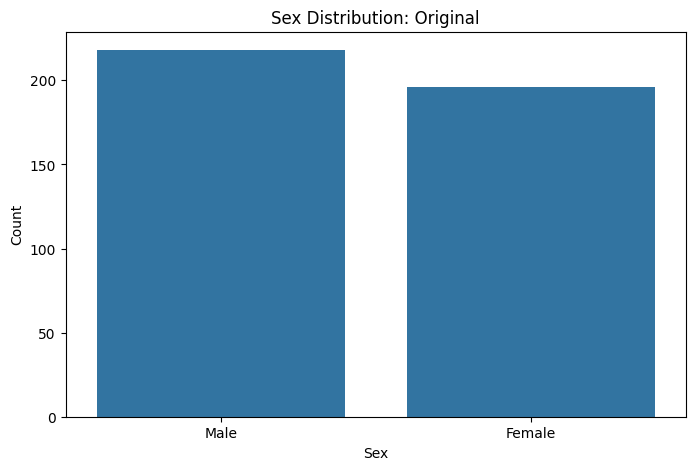

In [501]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Sex')
plt.title('Sex Distribution: Original')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

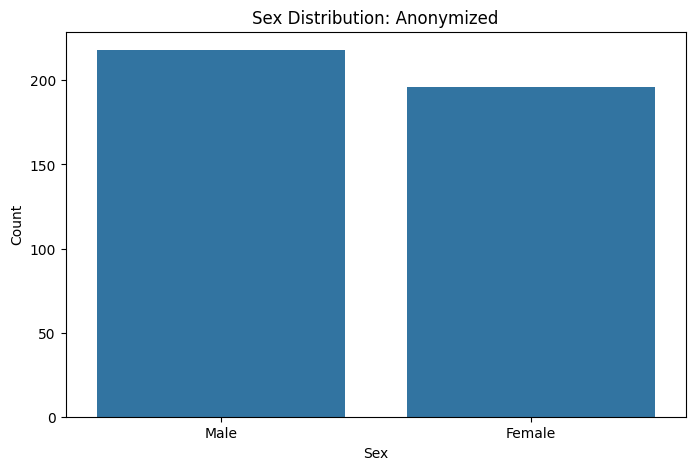

In [502]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df_Anonymization_1, x='Sex')
plt.title('Sex Distribution: Anonymized')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

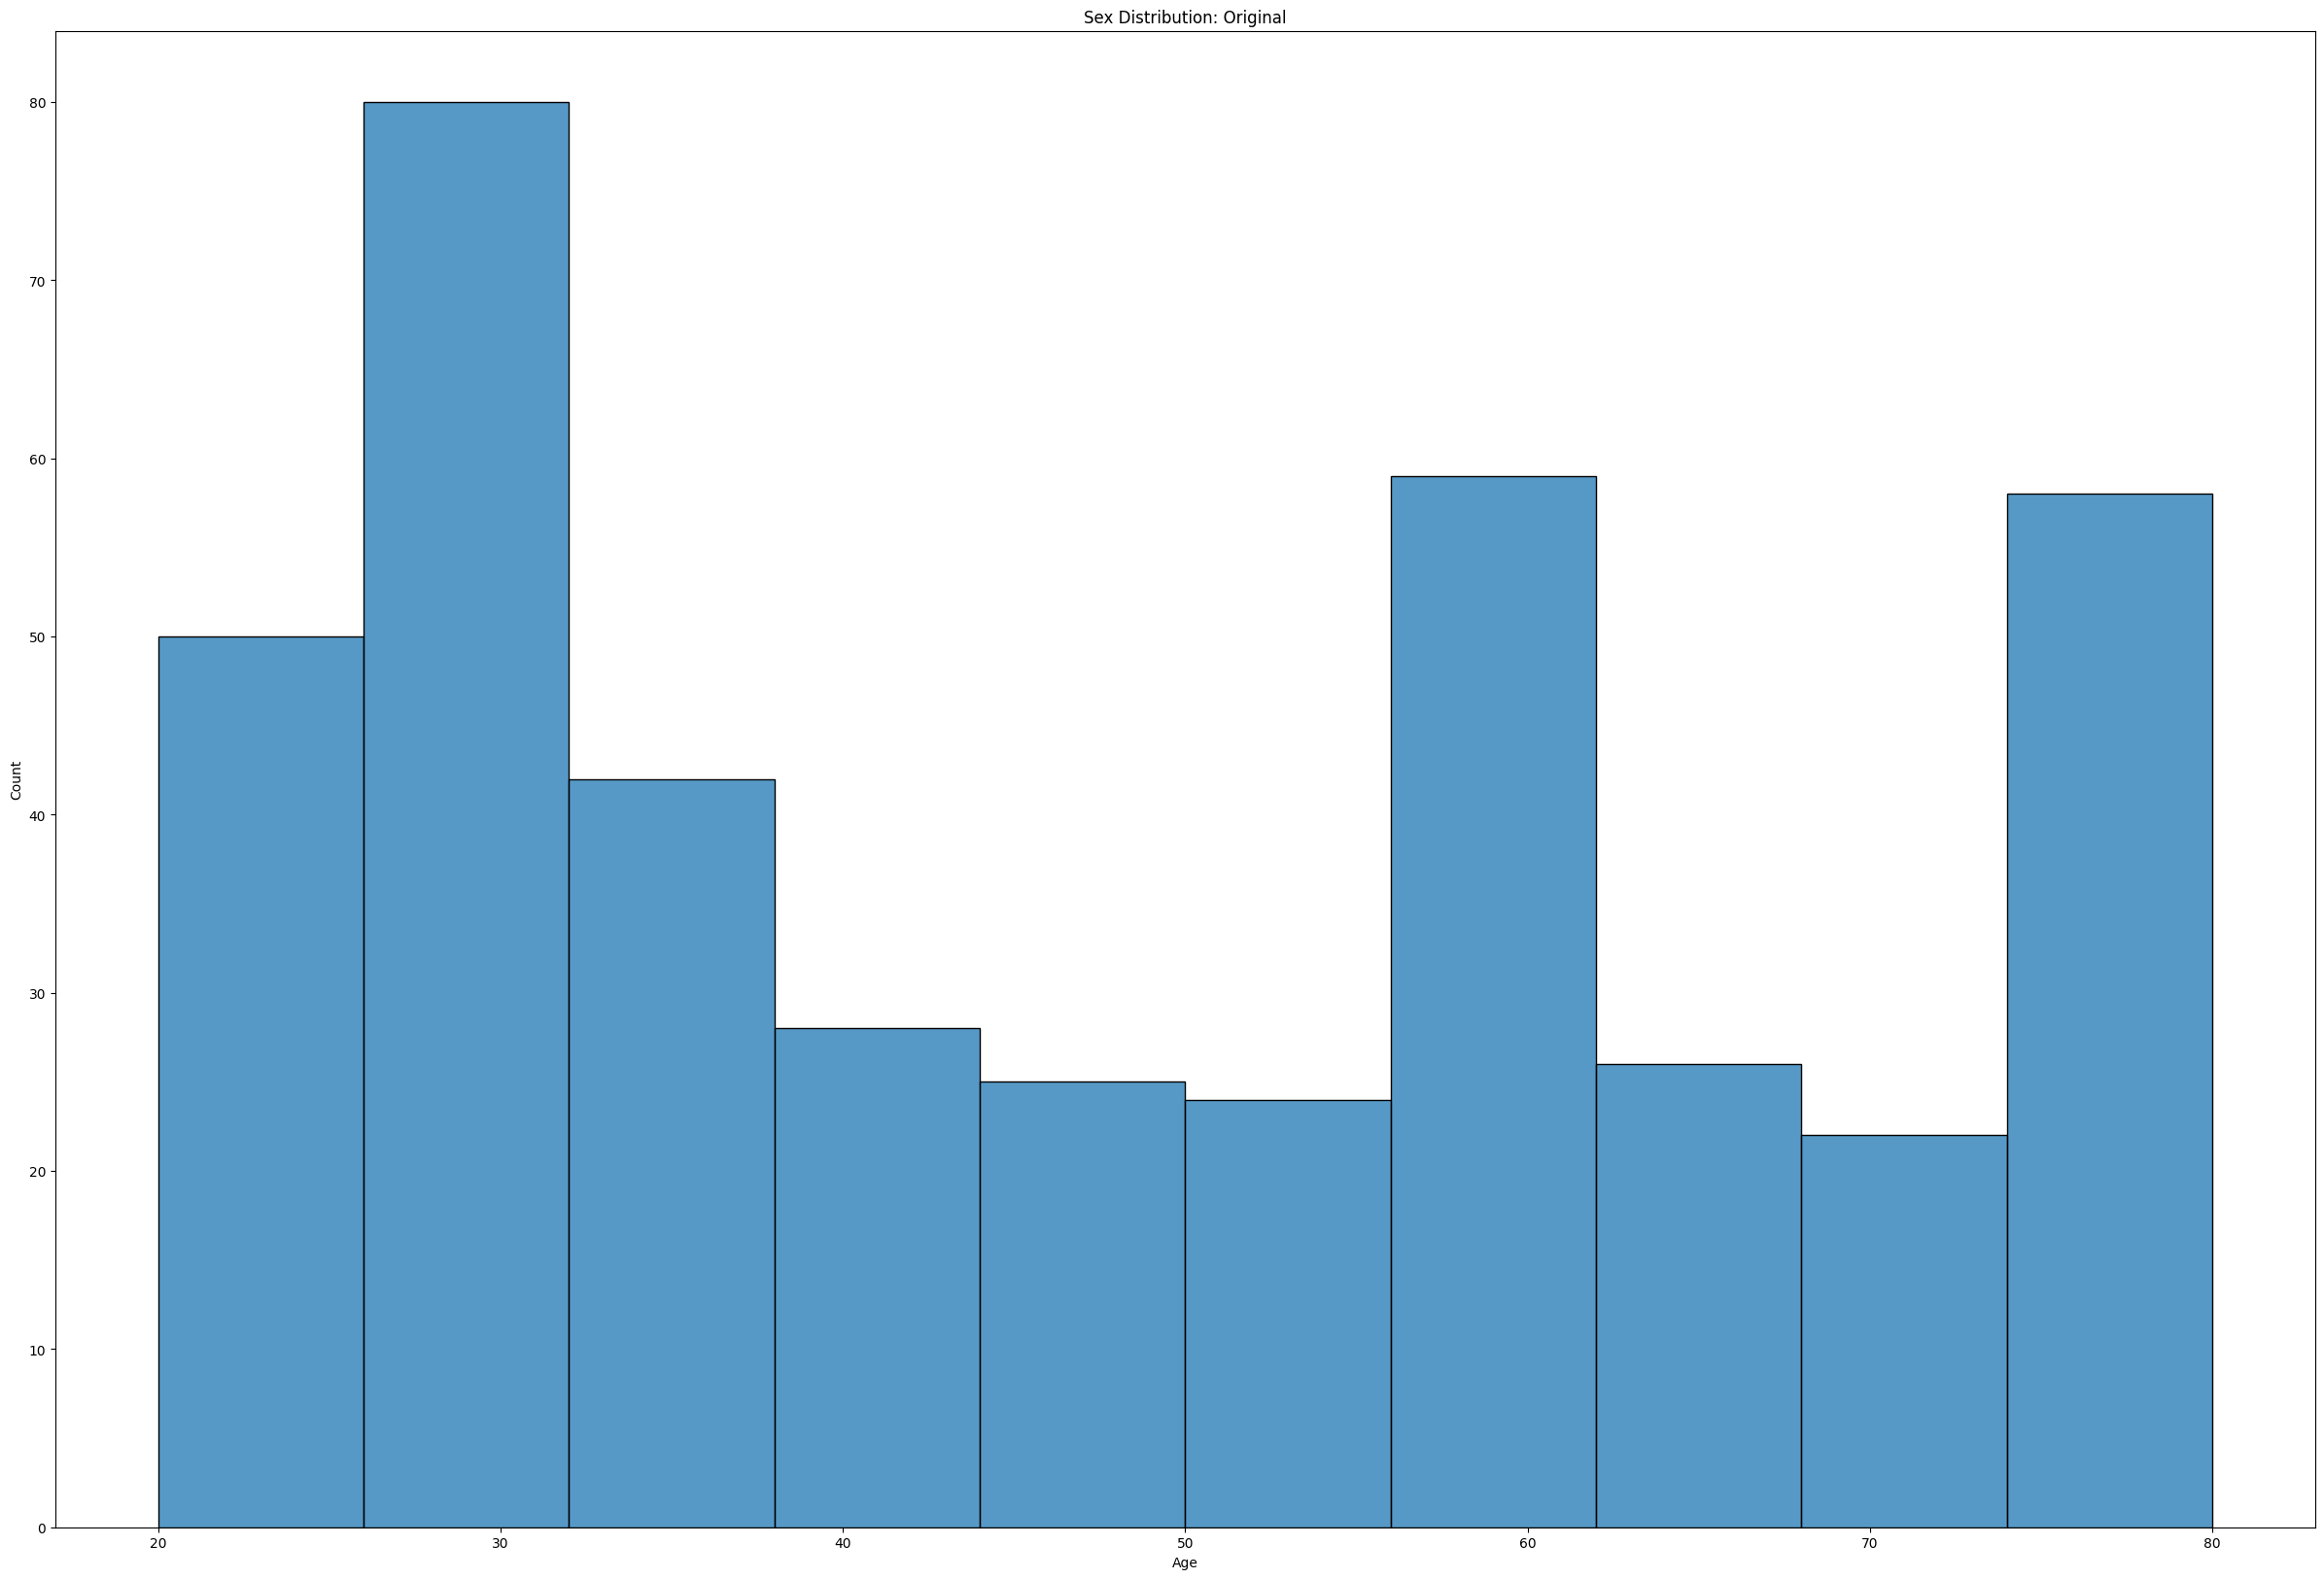

In [503]:
plt.figure(figsize=(30, 20))
sns.histplot(data=df, x='Age')
plt.title('Sex Distribution: Original')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

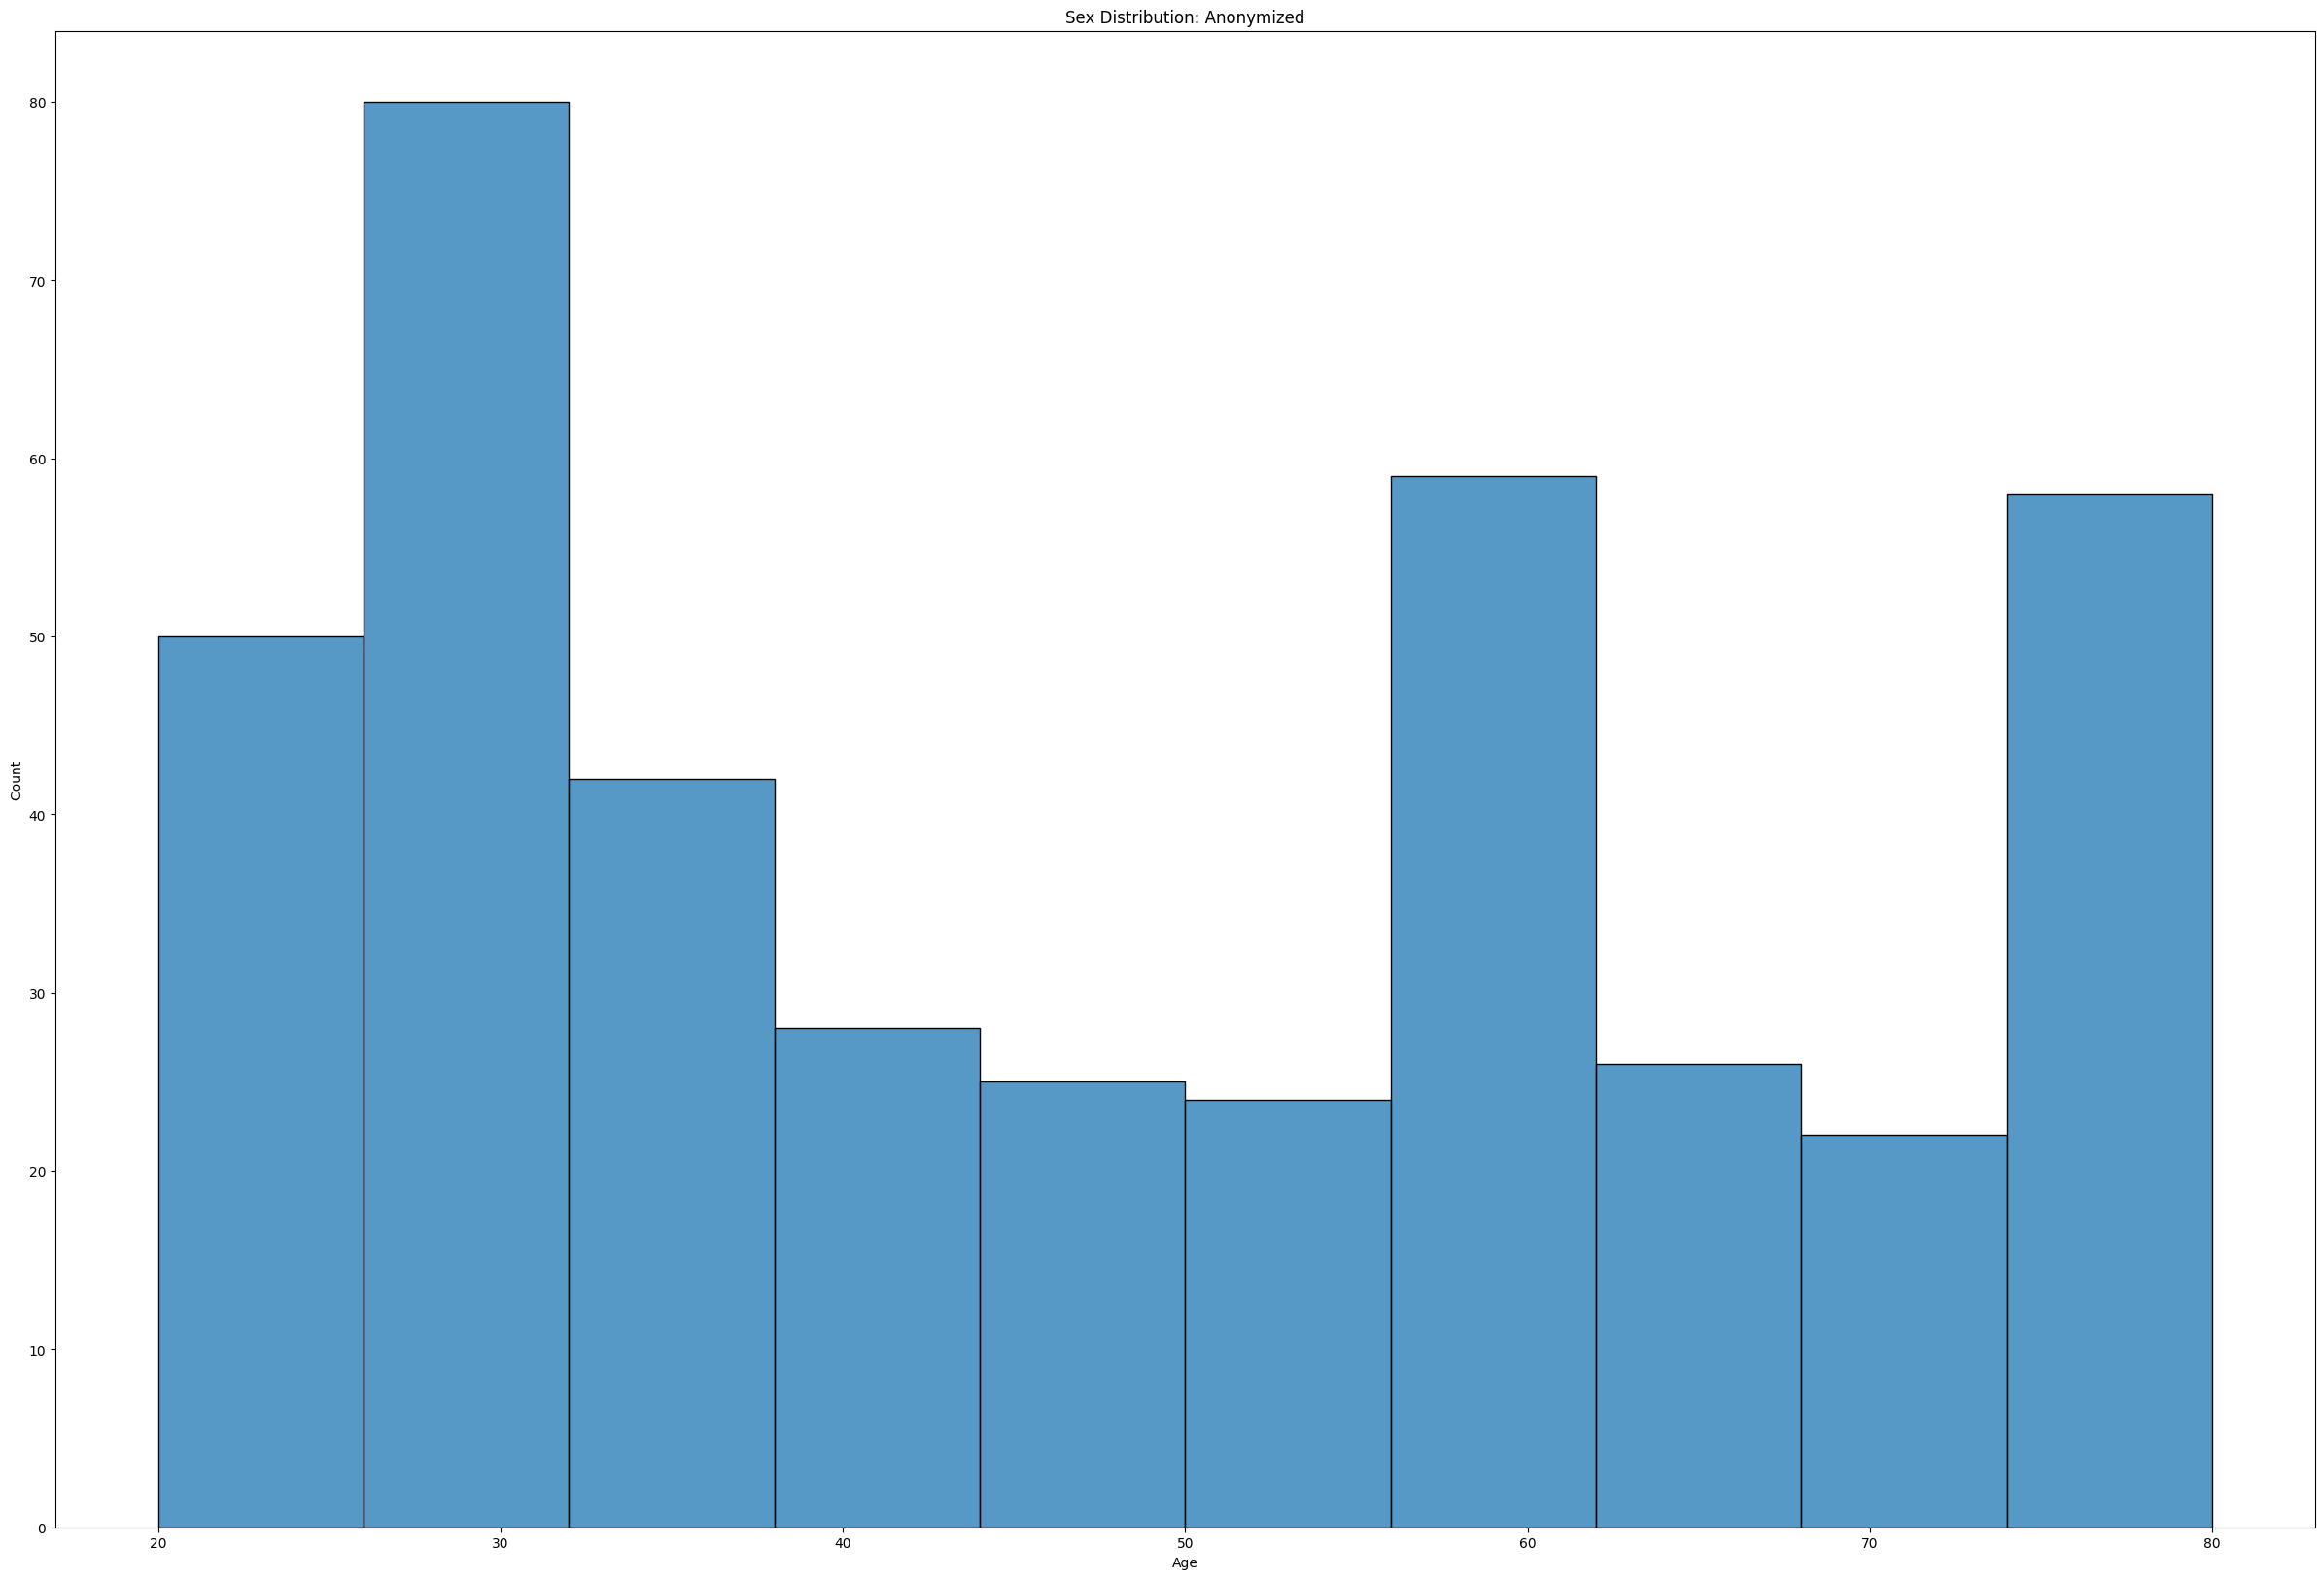

In [504]:
plt.figure(figsize=(30, 20))
sns.histplot(data=df, x='Age')
plt.title('Sex Distribution: Anonymized')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Utility of Anonymized Medical Records Dataset est bien.

### 3.2. Disease Prevalence Over Time: 

Does the anonymized dataset maintain the trends in disease prevalence across different time periods?

In [505]:
df['Disease'].value_counts()

Disease
Cancer           159
Hypertension      55
Asthma            53
Heart Disease     52
Diabetes          48
COVID-19          47
Name: count, dtype: int64

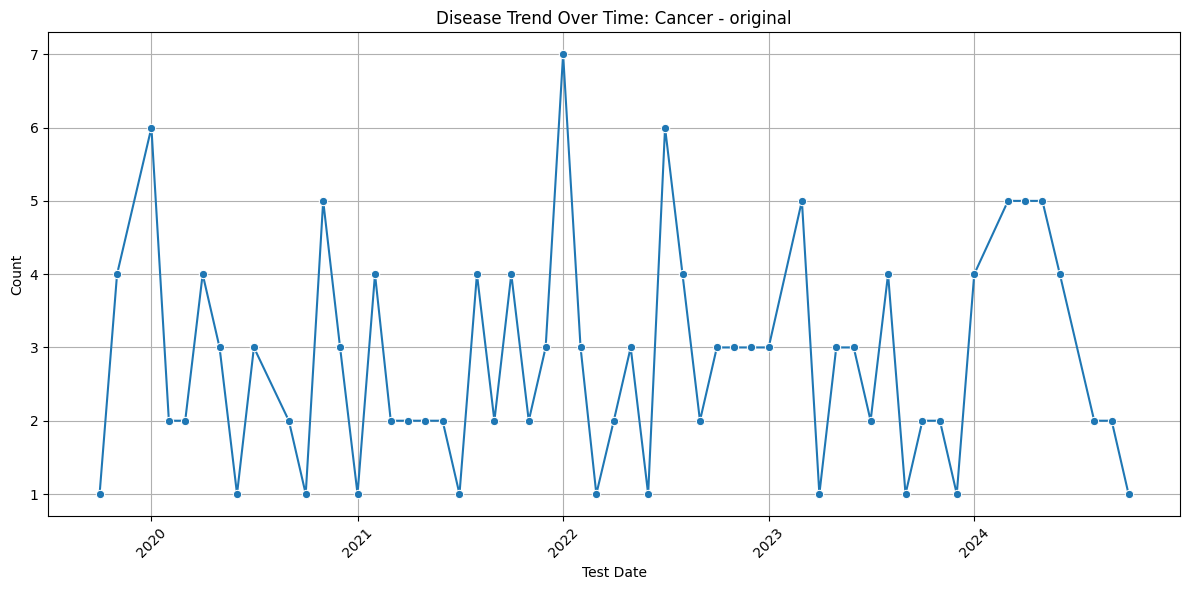

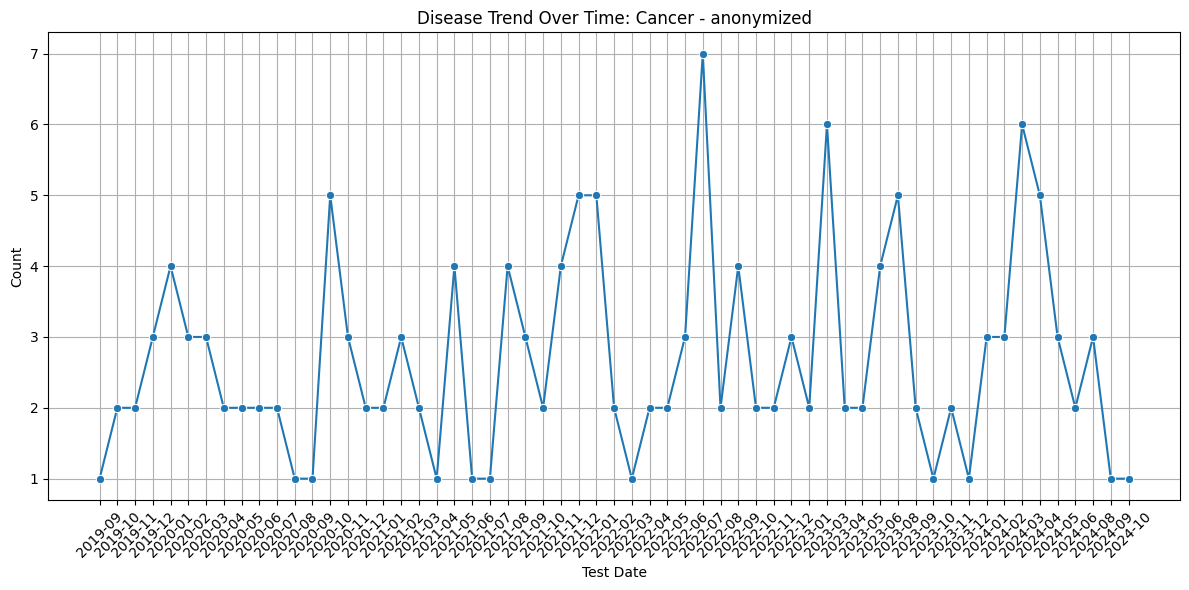

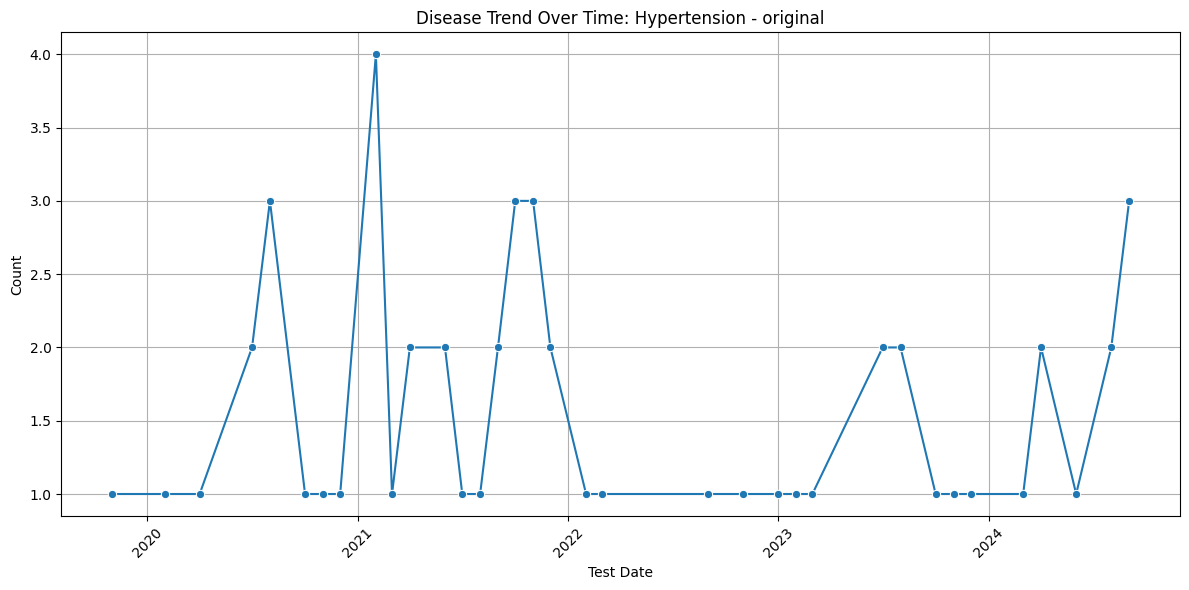

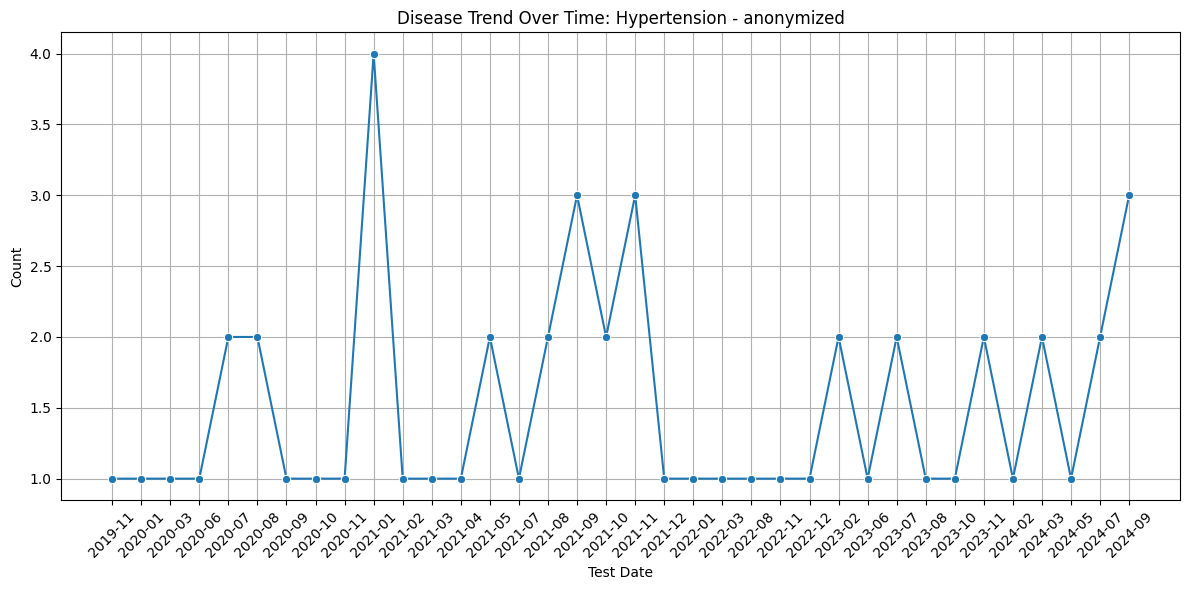

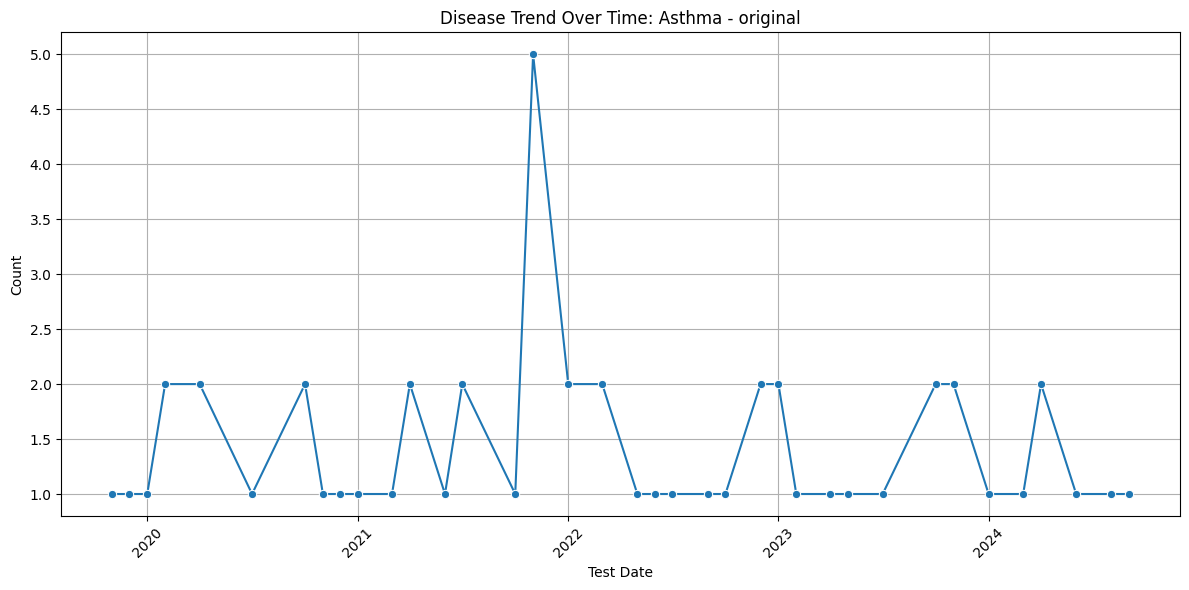

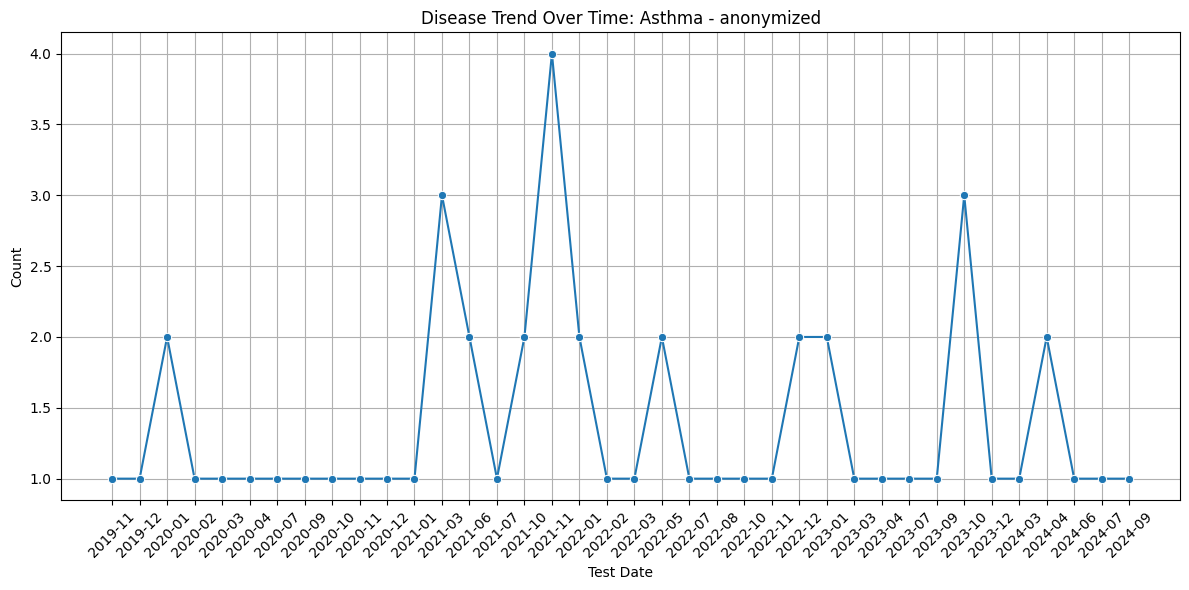

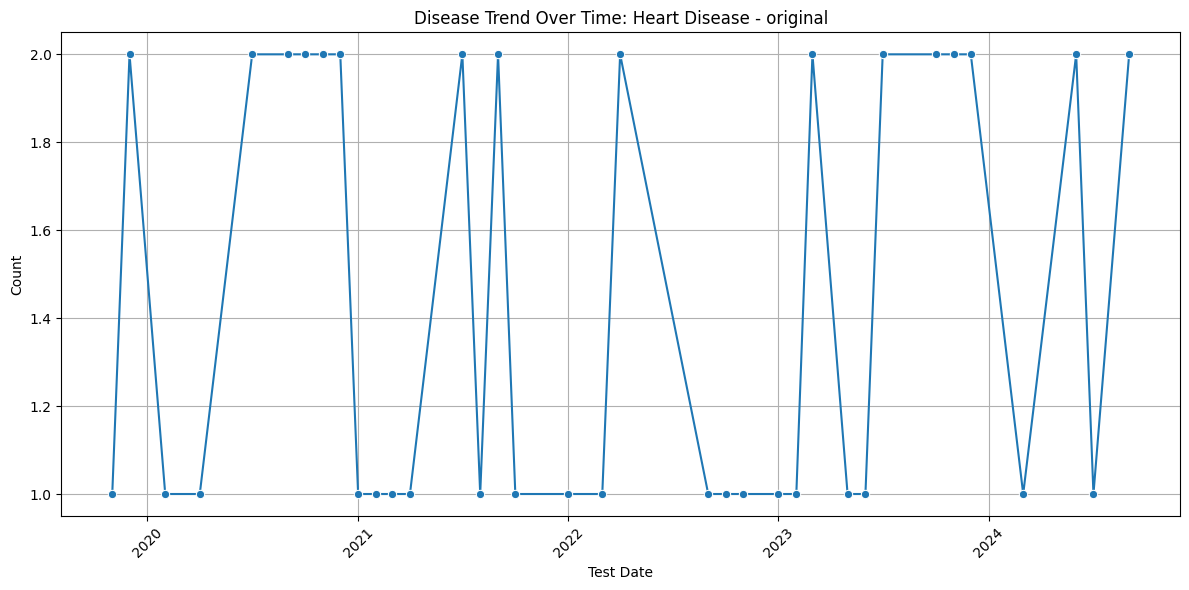

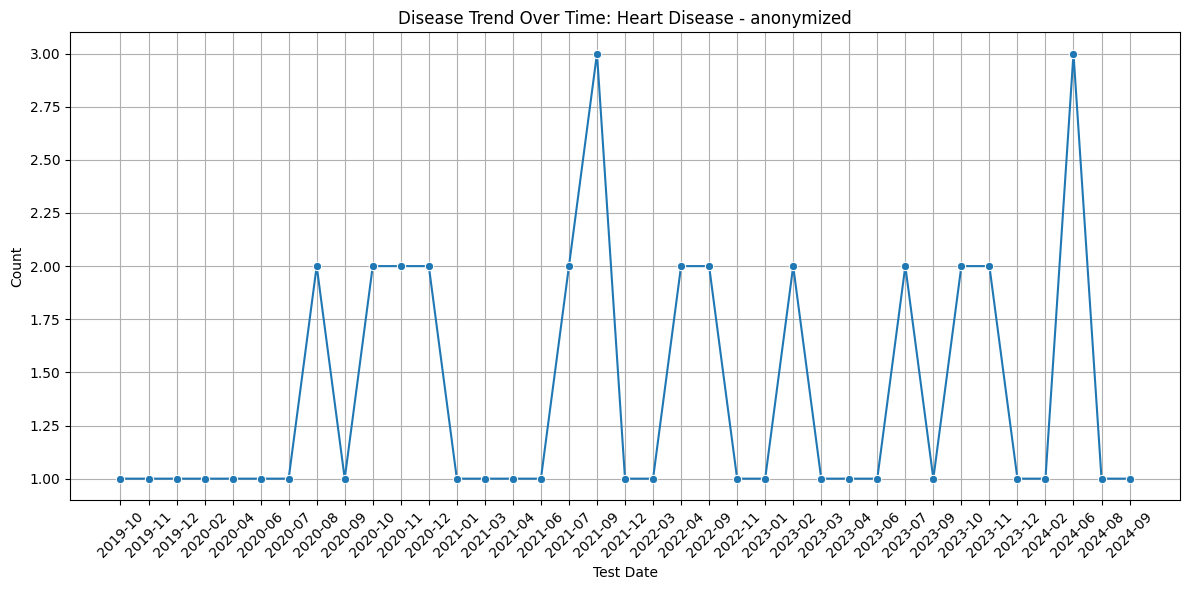

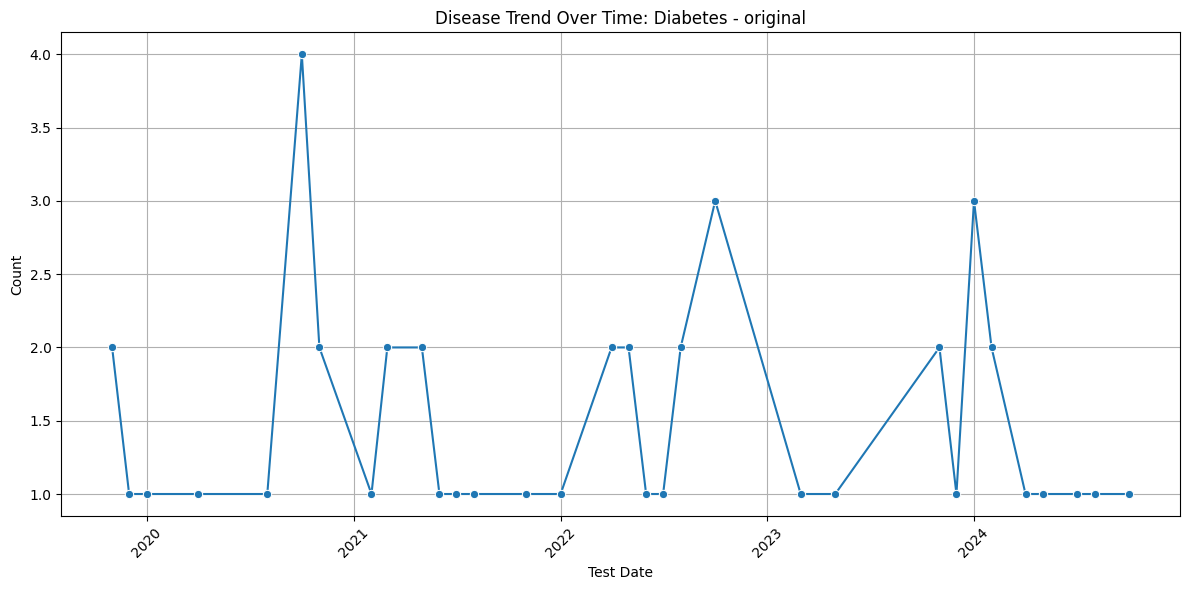

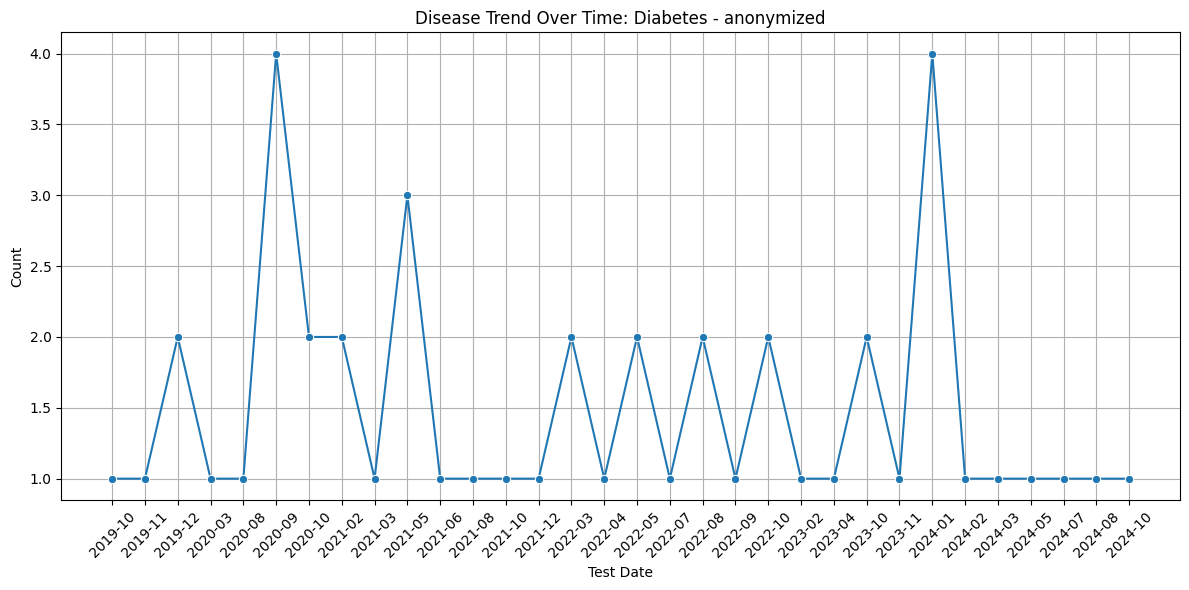

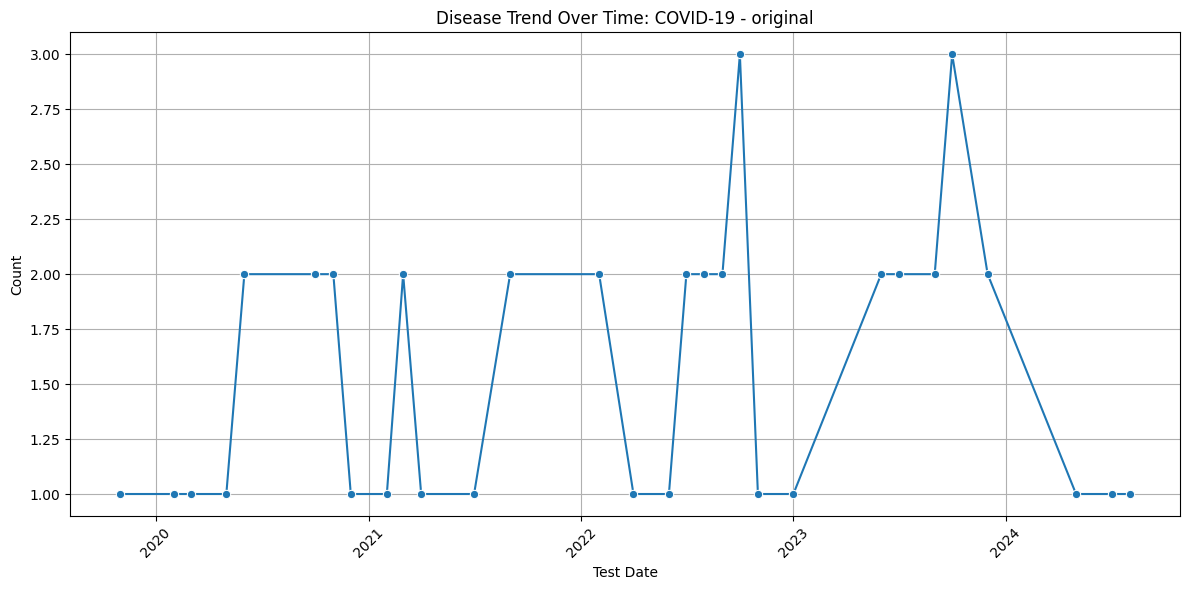

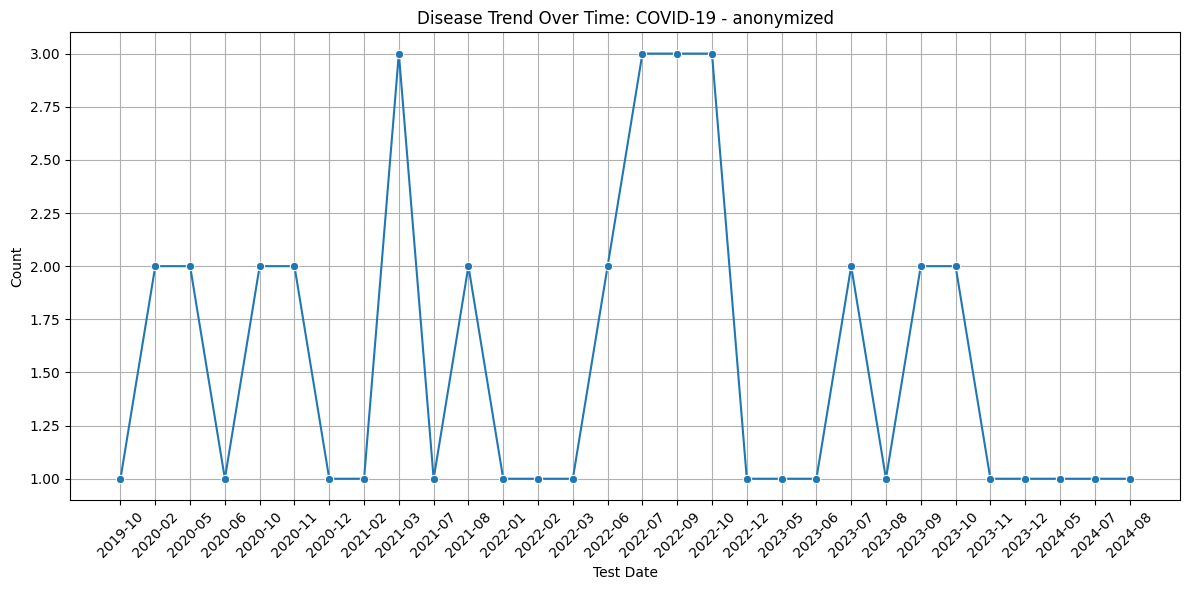

In [506]:
disease_name = ['Cancer', 'Hypertension', 'Asthma', 'Heart Disease', 'Diabetes', 'COVID-19']
df['Test_Date'] = pd.to_datetime(df['Test_Date'])
df['Test_Date'] = df['Test_Date'].dt.to_period('M').dt.to_timestamp()
trend_df = df.groupby(['Test_Date', 'Disease']).size().reset_index(name='Count')
trend_df_Anonymization = df_Anonymization_1.groupby(['Test_Date', 'Disease']).size().reset_index(name='Count')


for disease in disease_name:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=trend_df[trend_df['Disease'] == disease], x='Test_Date', y='Count', marker='o')
    plt.title(f'Disease Trend Over Time: {disease} - original')
    plt.xlabel('Test Date')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=trend_df_Anonymization[trend_df_Anonymization['Disease'] == disease], x='Test_Date', y='Count', marker='o')
    plt.title(f'Disease Trend Over Time: {disease} - anonymized')
    plt.xlabel('Test Date')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


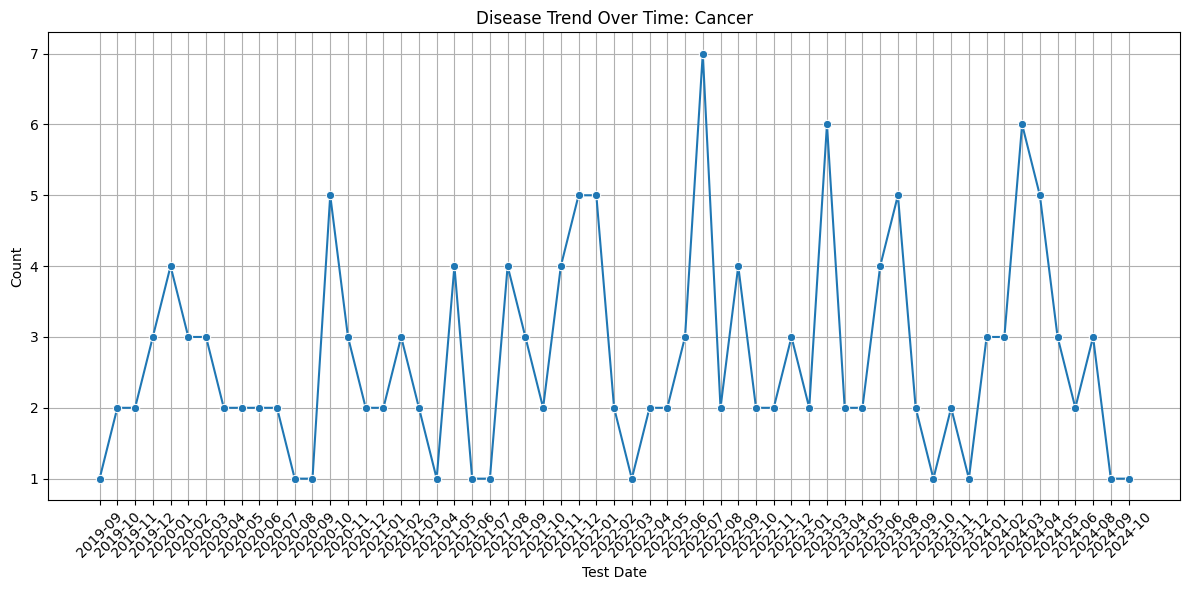

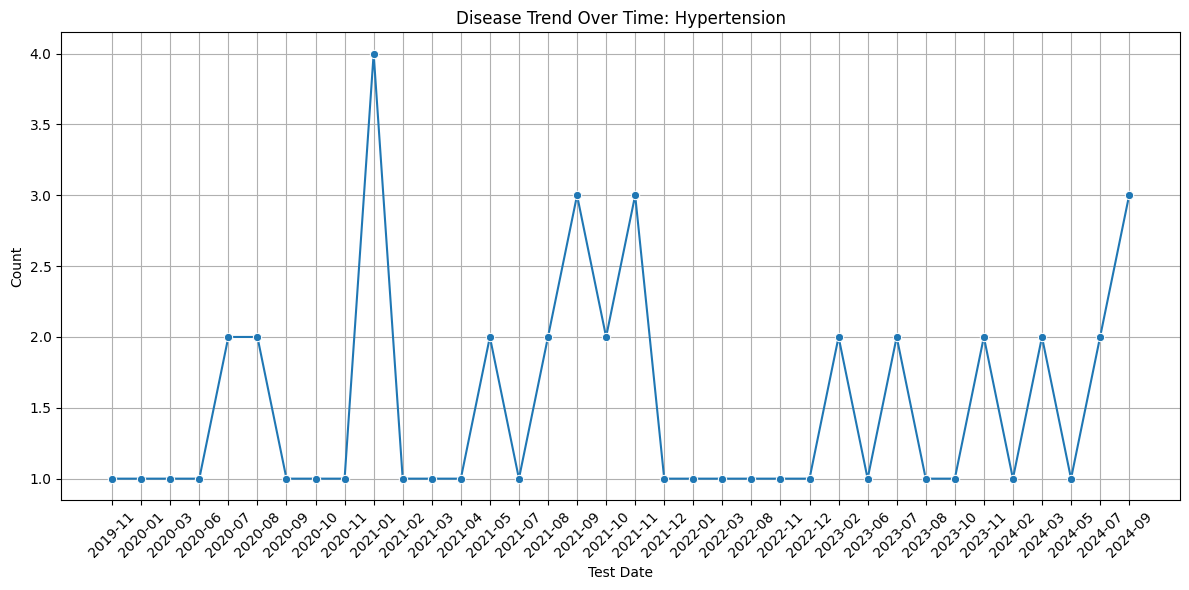

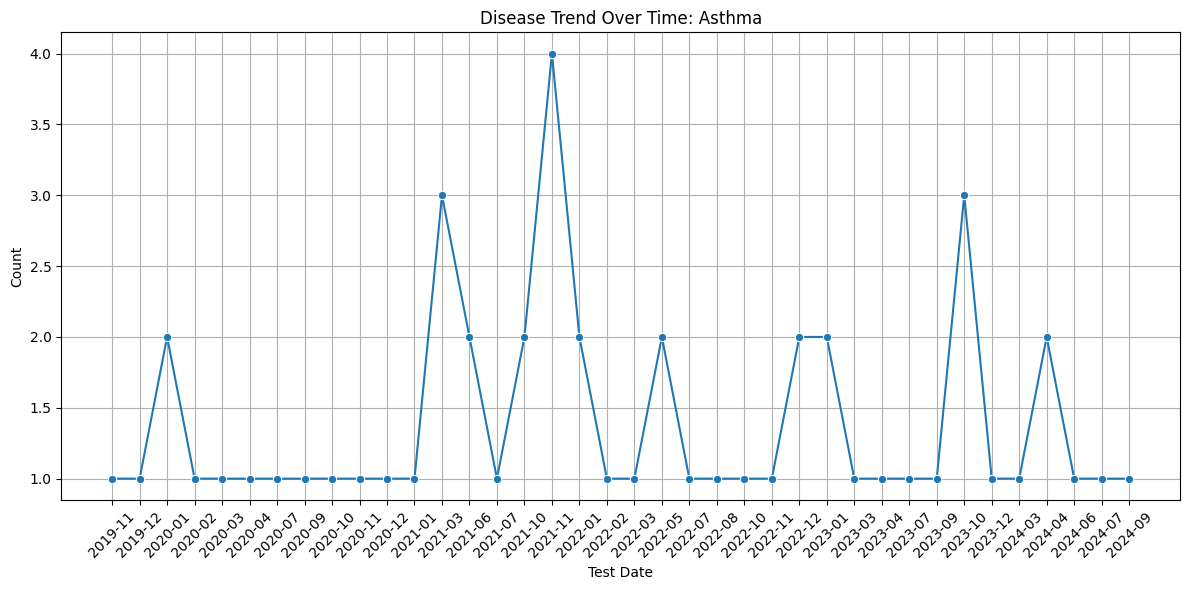

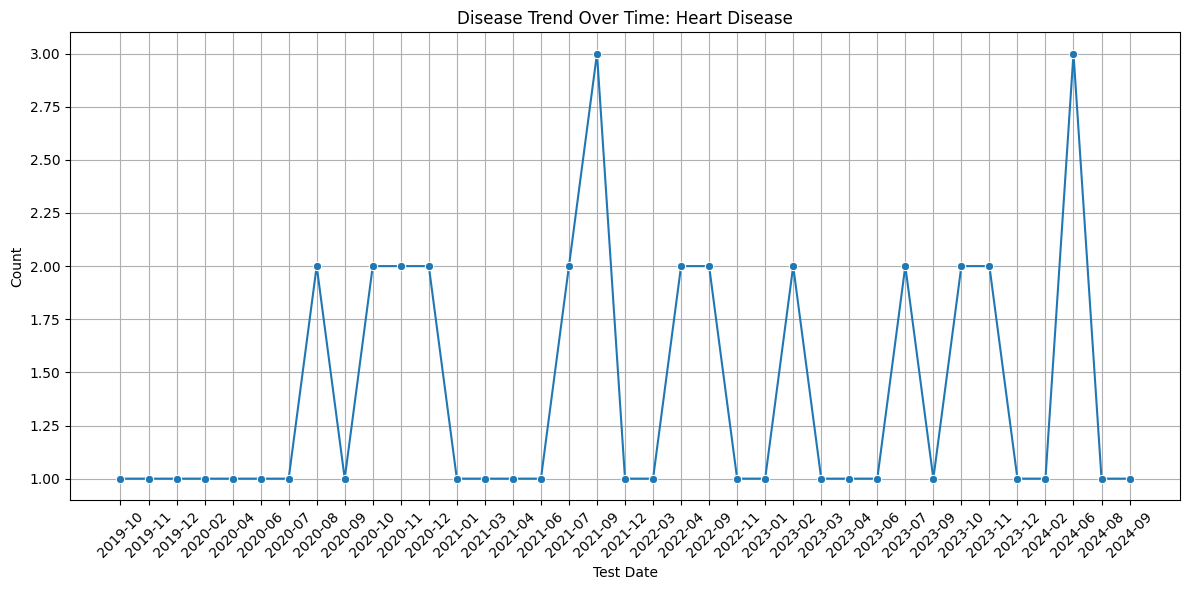

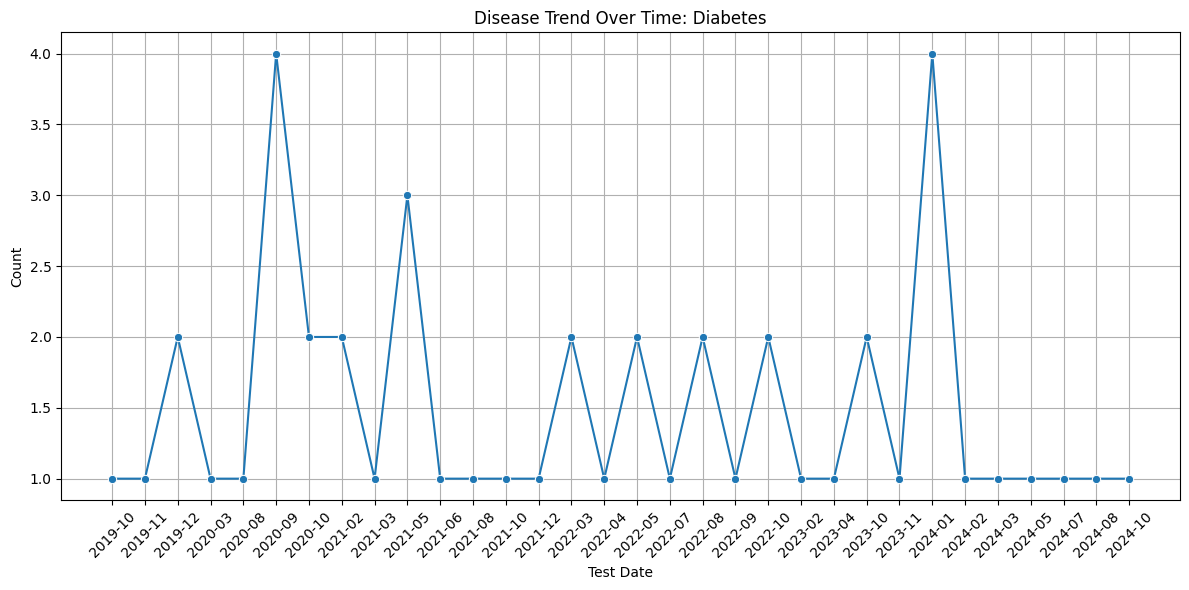

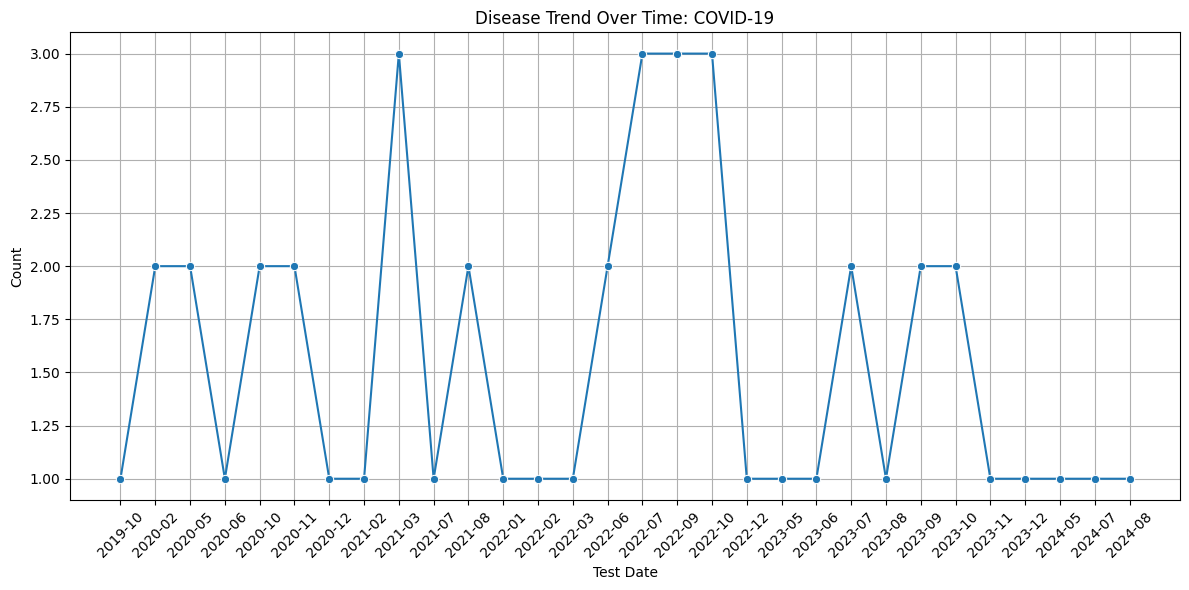

In [507]:
for disease in disease_name:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=trend_df_Anonymization[trend_df_Anonymization['Disease'] == disease], x='Test_Date', y='Count', marker='o')
    plt.title(f'Disease Trend Over Time: {disease}')
    plt.xlabel('Test Date')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Utility of Anonymized Medical Records Dataset est bien. La tendance générale n’a pas beaucoup changé. Nous avons utilisé la généralisation et l'ajout de bruits pour traiter l'attribut Test_Date. Alors ces données sont pas bcp de lignes. du coup c'est difficile de respecter k-anonymity, l-diversity. unility vs privacy trade-off.

### 3.3. Testing Frequency Analysis:Are the testing frequencies for various diseases preserved in the anonymized dataset compared to the original dataset?

C:\Users\30586\AppData\Local\Temp\ipykernel_9892\1720527721.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Disease', palette='viridis')


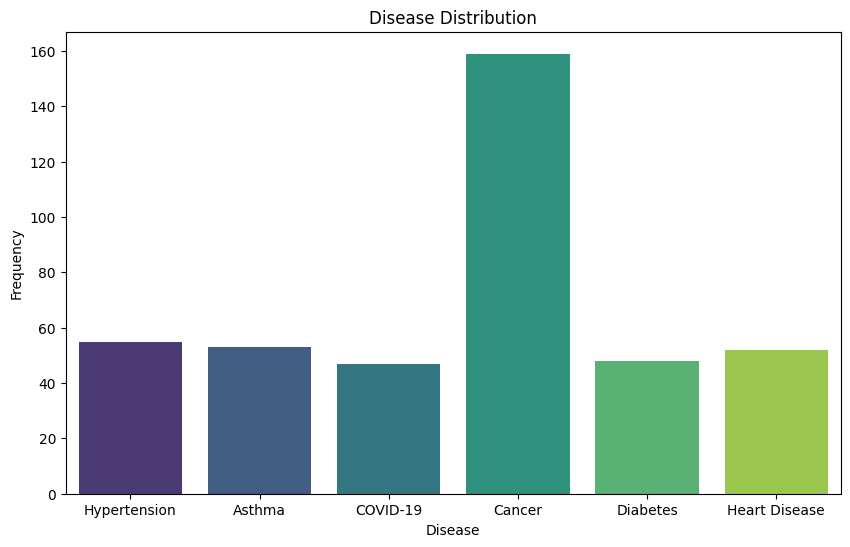

In [508]:
## Distribution of disease
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Disease', palette='viridis')
plt.title('Disease Distribution')
plt.xlabel('Disease')
plt.ylabel('Frequency')
plt.show()

Il y a pas de Rare diseases, du coup pas besoin de traiter l'attribut "Disease". s'il existe rare diseases, on peut essayer de reclasser disease(map(disease_map)),s'il y a plusieurs rare diseases; on peut utiliser others pour remplacer nom de rare diseases.